Cell 1: Imports & Setup

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!unzip -q "/content/drive/MyDrive/dataset/face_50k.zip"

In [ ]:
!unzip -q "/content/drive/MyDrive/dataset/animefacedataset.zip"

In [ ]:
import os
import itertools
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid

Cell 1: Prepare Dataset Folders and Visualize Samples

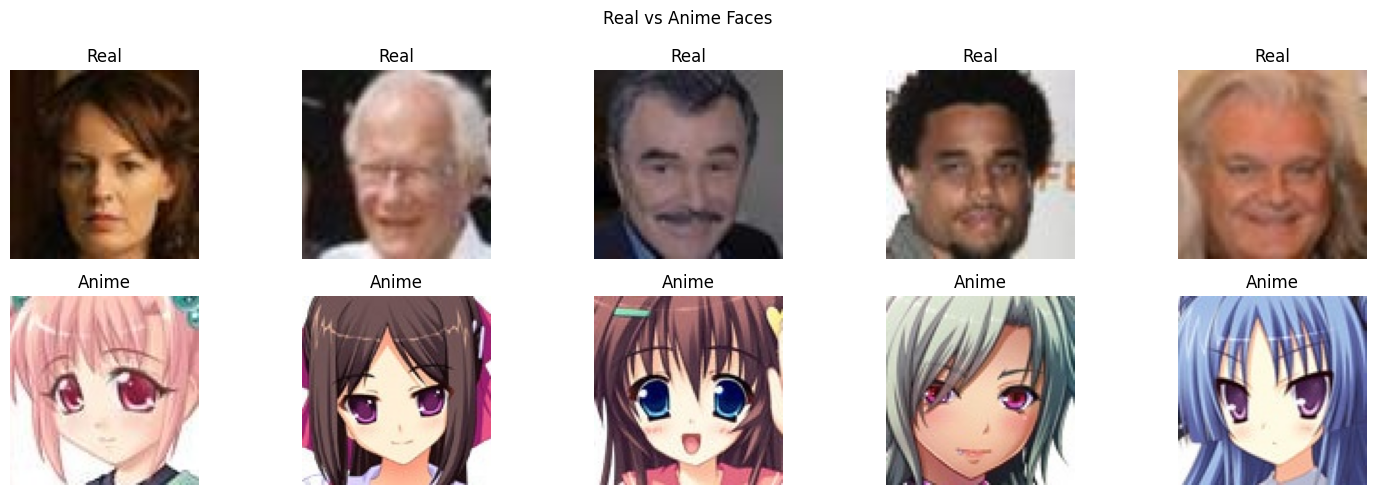

In [ ]:
import os, glob, shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Create directories
!mkdir -p /content/cyclegan_data/trainA
!mkdir -p /content/cyclegan_data/trainB

# Copy sample real and anime images
real_imgs = glob.glob("/content/50k/*.jpg")[:3000]
anime_imgs = glob.glob("/content/animefacedataset/versions/3/images/*.jpg")[:3000]

for f in real_imgs:
    shutil.copy(f, "/content/cyclegan_data/trainA/")
for f in anime_imgs:
    shutil.copy(f, "/content/cyclegan_data/trainB/")

# Sample visualization
fig, axs = plt.subplots(2, 5, figsize=(15, 5))
for i in range(5):
    axs[0, i].imshow(mpimg.imread(real_imgs[i]))
    axs[0, i].axis('off')
    axs[0, i].set_title("Real")
    axs[1, i].imshow(mpimg.imread(anime_imgs[i]))
    axs[1, i].axis('off')
    axs[1, i].set_title("Anime")
plt.suptitle("Real vs Anime Faces")
plt.tight_layout()
plt.show()


Cell 2: Load Dataset and Define Transforms

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import random

class UnpairedImageDataset(Dataset):
    def __init__(self, dirA, dirB, transform):
        self.files_A = sorted(glob.glob(os.path.join(dirA, '*.jpg')))
        self.files_B = sorted(glob.glob(os.path.join(dirB, '*.jpg')))
        self.transform = transform

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

    def __getitem__(self, idx):
        img_A = Image.open(self.files_A[idx % len(self.files_A)]).convert('RGB')
        img_B = Image.open(self.files_B[random.randint(0, len(self.files_B)-1)]).convert('RGB')
        return self.transform(img_A), self.transform(img_B)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = UnpairedImageDataset("/content/cyclegan_data/trainA", "/content/cyclegan_data/trainB", transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


Cell 3: Define CycleGAN Architecture

In [ ]:
import torch.nn as nn

def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=6):
        super().__init__()
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(in_channels, 64, 7),
                 nn.InstanceNorm2d(64),
                 nn.ReLU(inplace=True)]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResnetBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features // 2

        model += [nn.ReflectionPad2d(3),
                  nn.Conv2d(64, out_channels, 7),
                  nn.Tanh()]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        model = [nn.Conv2d(in_channels, 64, 4, 2, 1),
                 nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(64, 128, 4, 2, 1),
                  nn.InstanceNorm2d(128),
                  nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(128, 256, 4, 2, 1),
                  nn.InstanceNorm2d(256),
                  nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(256, 512, 4, 1, 1),
                  nn.InstanceNorm2d(512),
                  nn.LeakyReLU(0.2, inplace=True),
                  nn.Conv2d(512, 1, 4, 1, 1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


Cell 4: Training Setup

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G_AB = Generator().to(device).apply(weights_init)
G_BA = Generator().to(device).apply(weights_init)
D_A = Discriminator().to(device).apply(weights_init)
D_B = Discriminator().to(device).apply(weights_init)

criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()

lr = 0.0002
optimizer_G = torch.optim.Adam(list(G_AB.parameters()) + list(G_BA.parameters()), lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(0.5, 0.999))


Cell 5: Training Loop + 5 Visualizations

[Epoch 1/10] Loss_G: 6.5246 | Loss_DA: 0.4868 | Loss_DB: 0.4775


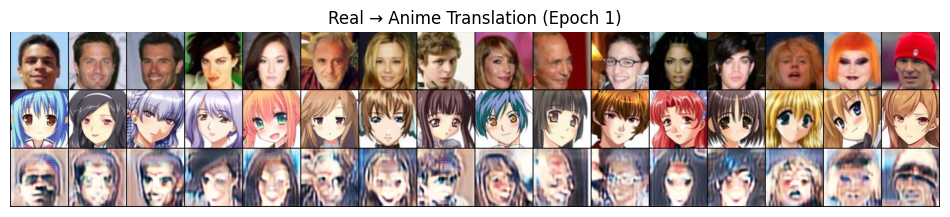

[Epoch 2/10] Loss_G: 4.8095 | Loss_DA: 0.2654 | Loss_DB: 0.2642


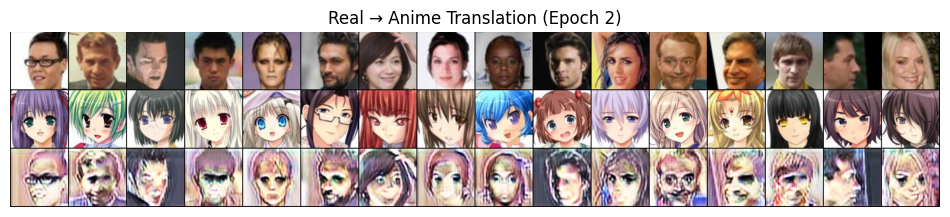

[Epoch 3/10] Loss_G: 4.4387 | Loss_DA: 0.2333 | Loss_DB: 0.2029


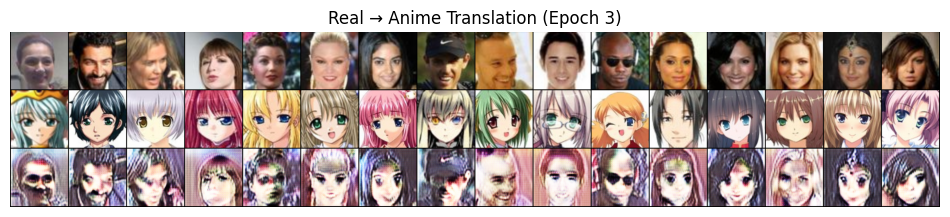

[Epoch 4/10] Loss_G: 4.1557 | Loss_DA: 0.2133 | Loss_DB: 0.2218


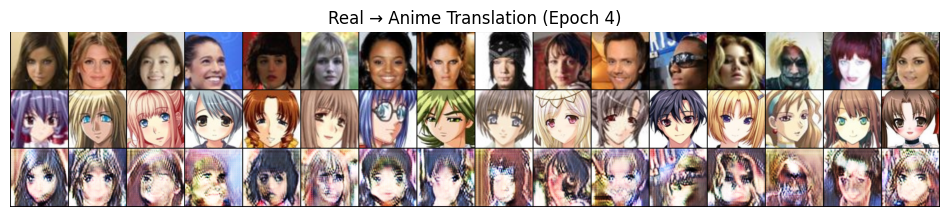

[Epoch 5/10] Loss_G: 4.0640 | Loss_DA: 0.2071 | Loss_DB: 0.1861


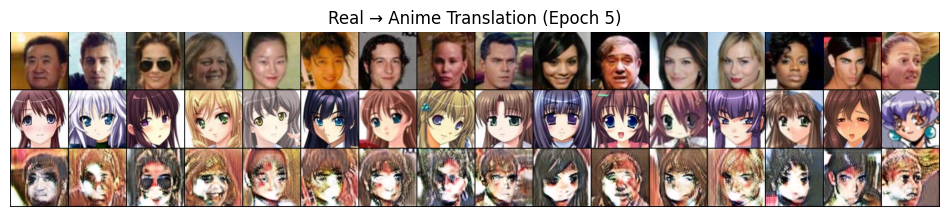

[Epoch 6/10] Loss_G: 3.9890 | Loss_DA: 0.2535 | Loss_DB: 0.1917


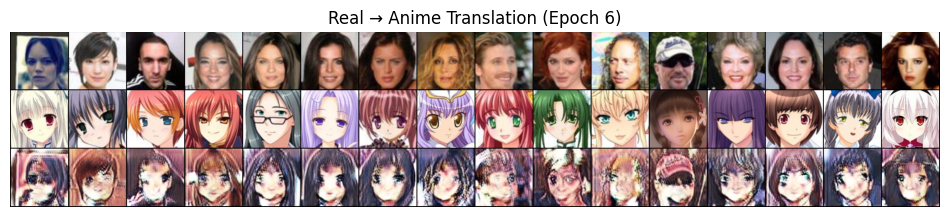

[Epoch 7/10] Loss_G: 3.7657 | Loss_DA: 0.1895 | Loss_DB: 0.1851


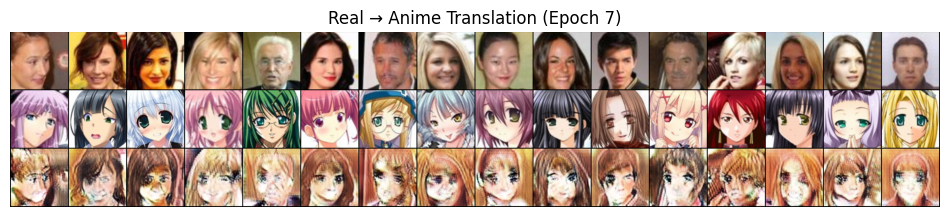

[Epoch 8/10] Loss_G: 3.7874 | Loss_DA: 0.1949 | Loss_DB: 0.1808


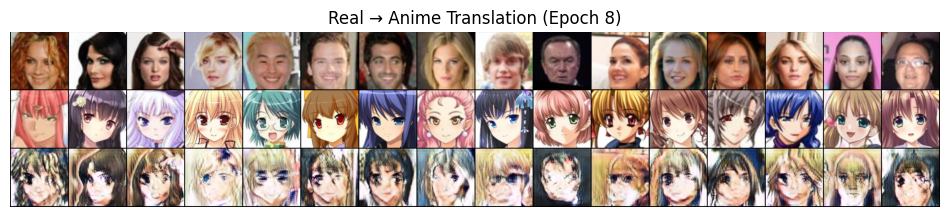

[Epoch 9/10] Loss_G: 3.6916 | Loss_DA: 0.2211 | Loss_DB: 0.1841


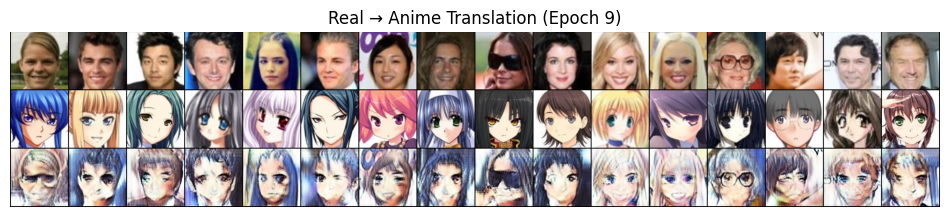

[Epoch 10/10] Loss_G: 3.6651 | Loss_DA: 0.1933 | Loss_DB: 0.1699


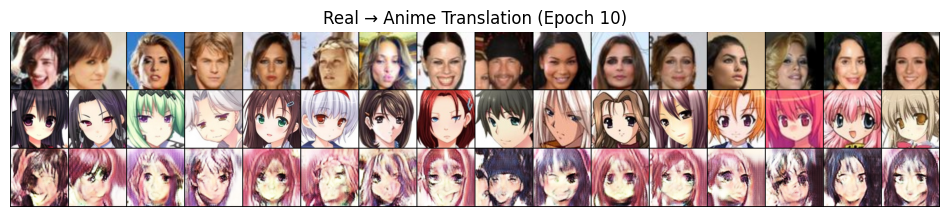

In [ ]:
from torchvision.utils import make_grid
import numpy as np

def denorm(x):
    return x * 0.5 + 0.5

num_epochs = 10
loss_G_list = []
loss_DA_list = []
loss_DB_list = []

for epoch in range(num_epochs):
    epoch_loss_G = 0.0
    epoch_loss_DA = 0.0
    epoch_loss_DB = 0.0
    num_batches = 0

    for i, (real_A, real_B) in enumerate(dataloader):
        real_A = real_A.to(device)
        real_B = real_B.to(device)
        valid = torch.ones(real_A.size(0), 1, 14, 14).to(device)
        fake = torch.zeros(real_A.size(0), 1, 14, 14).to(device)

        # === Train Generators ===
        optimizer_G.zero_grad()
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_G = loss_GAN_AB + loss_GAN_BA + 10.0 * (loss_cycle_A + loss_cycle_B)
        loss_G.backward()
        optimizer_G.step()

        # === Train Discriminator A ===
        optimizer_D_A.zero_grad()
        loss_D_A = (criterion_GAN(D_A(real_A), valid) + criterion_GAN(D_A(fake_A.detach()), fake)) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        # === Train Discriminator B ===
        optimizer_D_B.zero_grad()
        loss_D_B = (criterion_GAN(D_B(real_B), valid) + criterion_GAN(D_B(fake_B.detach()), fake)) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

        # Accumulate losses
        epoch_loss_G += loss_G.item()
        epoch_loss_DA += loss_D_A.item()
        epoch_loss_DB += loss_D_B.item()
        num_batches += 1

    # Average losses per epoch
    loss_G_list.append(epoch_loss_G / num_batches)
    loss_DA_list.append(epoch_loss_DA / num_batches)
    loss_DB_list.append(epoch_loss_DB / num_batches)

    print(f"[Epoch {epoch+1}/{num_epochs}] "
          f"Loss_G: {loss_G_list[-1]:.4f} | "
          f"Loss_DA: {loss_DA_list[-1]:.4f} | "
          f"Loss_DB: {loss_DB_list[-1]:.4f}")


    # Visualization 1: Translated Real → Anime
    # with torch.no_grad():
    #     real_sample, _ = next(iter(dataloader))
    #     real_A = real_sample[0].unsqueeze(0).to(device)
    #     fake_B = G_AB(real_A).cpu()
    #     grid = make_grid(denorm(fake_B), nrow=1)
    #     plt.figure(figsize=(4, 4))
    #     plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    #     plt.title(f"Translated Real → Anime (Epoch {epoch+1})")
    #     plt.axis('off')
    #     plt.show()
        # Visualization: Real → Anime (Real, Target, Generated)
    with torch.no_grad():
        sample = next(iter(dataloader))
        real_A = sample[0].to(device)         # Real image (e.g., human face)
        real_B = sample[1].to(device)         # Target (e.g., anime face)
        fake_B = G_AB(real_A).cpu()           # Generated anime face

        # Bring everything to CPU and denormalize
        real_A = denorm(real_A.cpu())
        real_B = denorm(real_B.cpu())
        fake_B = denorm(fake_B)

        # Create a grid with: [Real | Target | Generated]
        comparison_grid = make_grid(
            torch.cat([real_A, real_B, fake_B], dim=0), nrow=real_A.size(0)
        )

        # Plot
        plt.figure(figsize=(12, 4))
        plt.imshow(np.transpose(comparison_grid.numpy(), (1, 2, 0)))
        plt.title(f"Real → Anime Translation (Epoch {epoch+1})")
        plt.axis('off')
        plt.show()



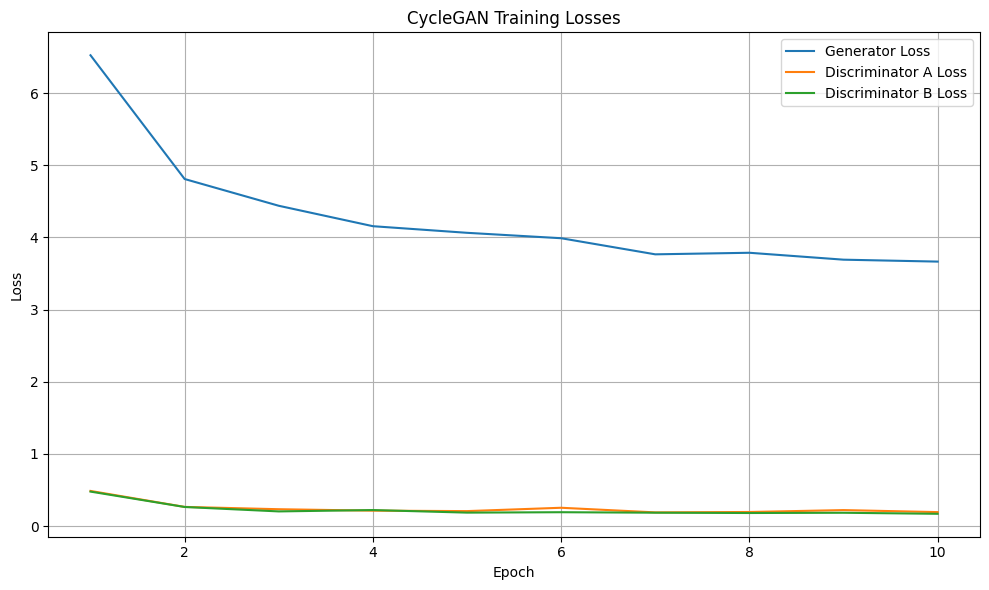

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_G_list, label="Generator Loss")
plt.plot(epochs, loss_DA_list, label="Discriminator A Loss")
plt.plot(epochs, loss_DB_list, label="Discriminator B Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CycleGAN Training Losses")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
